In [33]:
from __future__ import annotations

import json
import os
import re
from pathlib import Path
from typing import (
    Any,
    Union,  # noqa: F401
)
import random
import numpy as np
import pandas as pd
import anndata as ad
from scanpy import logging as logg
from scipy.sparse import csr_matrix
from sklearn import neighbors
import squidpy as sq
import scanpy as sc
import scipy
import matplotlib.pyplot as plt
import matplotlib

from squidpy._constants._pkg_constants import Key
from squidpy.datasets._utils import PathLike
from squidpy.read._utils import _load_image, _read_counts

from cell2location import run_colocation


In [34]:
merge_dataset = sc.read_h5ad("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/naive_1/sp_c2c_annotated_GPU.h5ad")

In [35]:
merge_dataset

AnnData object with n_obs × n_vars = 3525 × 15184
    obs: 'in_tissue', 'array_row', 'array_col', 'total_counts', 'location', 'spot_id', 'basement_layer', 'centre', 'sections', 'leiden_cluster', 'length', 'depth', 'unrolledSections', '_indices', '_scvi_batch', '_scvi_labels', 'Activated Cd4+ T cell', 'B cell', 'Basophil', 'Cd4+ T cell', 'Cd8+ T cell', 'DC', 'Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'GC B cell', 'Goblet', 'ILC1', 'ILC2', 'ILC3', 'LTi cell', 'Macrophage', 'Mast cell', 'NK cell', 'NKT cell', 'Neutrophil', 'Plasma cell', 'Stem', 'TA', 'TA.Early', 'Tuft', 'gammaDelta T cell', 'pDC'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'diffmap_evals', 'draw_graph', 'leiden_cluster_sizes', 'location_colors', 'mod', 'neighbors', 'paga', 'spatial'
    obsm: 'X_diffmap', 'X_draw_graph_kk', 'adjusted_spatial', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [36]:
#save the 'adjusted_spatial' obs as 'length_depth'
merge_dataset.obsm['length_depth'] = merge_dataset.obsm['adjusted_spatial'].copy()

#concatenate the 'adjusted_spatial' and 'spatial' obs together. This is so cell2location can break up the distinct sections 
#Perhaps I could add up the lengths of all the sections, then change their values to be seperated across the sum of the lengths (make sure there are gaps between them)

#save the 'spatial' obs as 'old_spatial'
merge_dataset.obsm['old_spatial'] = merge_dataset.obsm['spatial'].copy()


#make the 'spatial' obs equal to the 'adjusted_spatial', so the uns matches (cell2location NMF requires this, otherwise it has problems)
merge_dataset.obsm['spatial'] = merge_dataset.obsm['adjusted_spatial'].copy()

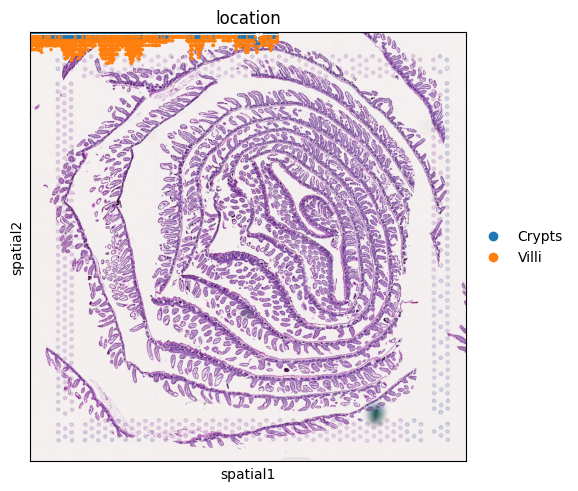

In [37]:
sq.pl.spatial_scatter(merge_dataset, color = "location")


In [38]:
res_dict, merge_dataset = run_colocation(
    merge_dataset,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': [5], # IMPORTANT: use a wider range of the number of factors (5-30)
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/naive_1/colocatedComb/'}
)


res_dict['n_fact5']['mod'].plot_cell_type_loadings()
plt.savefig("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/naive_1/5_factor_NMF.pdf",
                bbox_inches='tight')
plt.close()

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_3525locations_27factors


/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


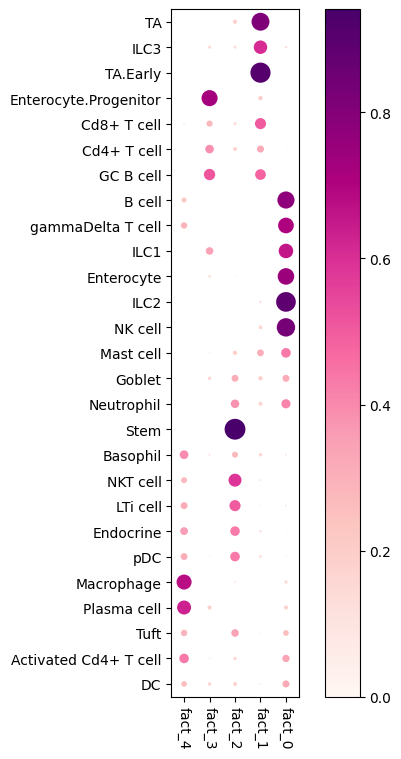

In [39]:
res_dict['n_fact5']['mod'].plot_cell_type_loadings()

In [40]:
merge_dataset.obsm['spatial'] = merge_dataset.obsm['old_spatial'].copy()
merge_dataset.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'total_counts', 'location',
       'spot_id', 'basement_layer', 'centre', 'sections', 'leiden_cluster',
       'length', 'depth', 'unrolledSections', '_indices', '_scvi_batch',
       '_scvi_labels', 'Activated Cd4+ T cell', 'B cell', 'Basophil',
       'Cd4+ T cell', 'Cd8+ T cell', 'DC', 'Endocrine', 'Enterocyte',
       'Enterocyte.Progenitor', 'GC B cell', 'Goblet', 'ILC1', 'ILC2', 'ILC3',
       'LTi cell', 'Macrophage', 'Mast cell', 'NK cell', 'NKT cell',
       'Neutrophil', 'Plasma cell', 'Stem', 'TA', 'TA.Early', 'Tuft',
       'gammaDelta T cell', 'pDC', 'sample', 'mean_nUMI_factorsfact_0',
       'mean_nUMI_factorsfact_1', 'mean_nUMI_factorsfact_2',
       'mean_nUMI_factorsfact_3', 'mean_nUMI_factorsfact_4'],
      dtype='object')

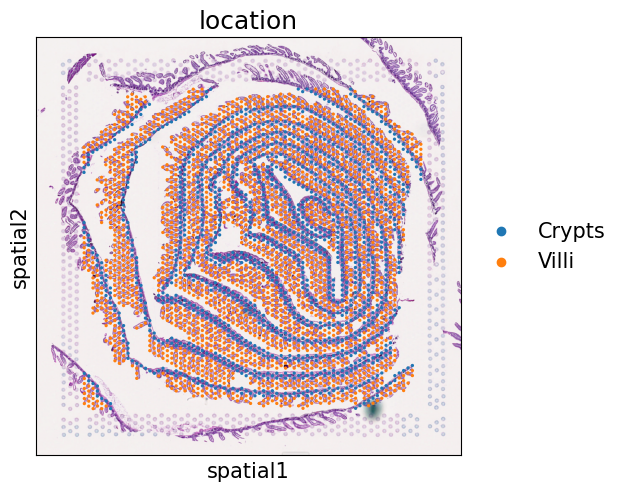

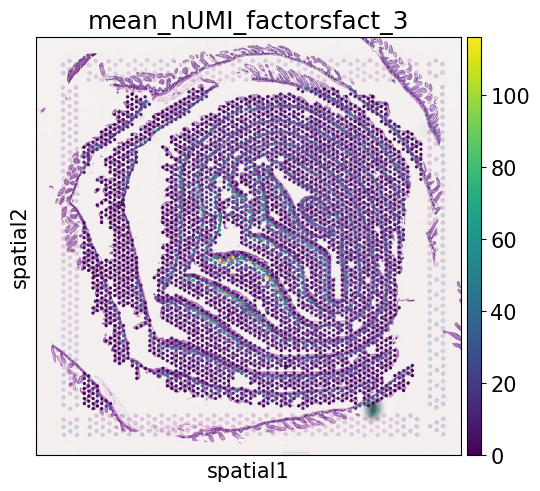

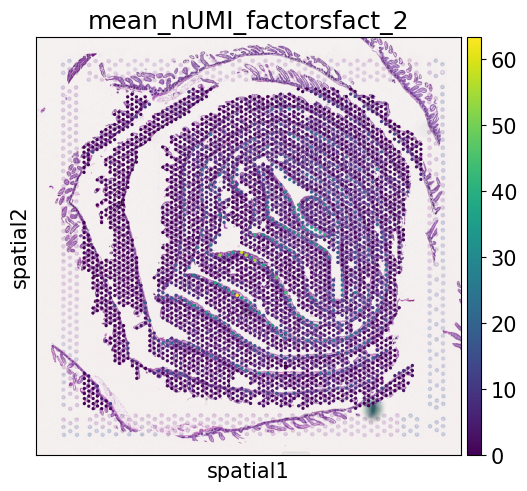

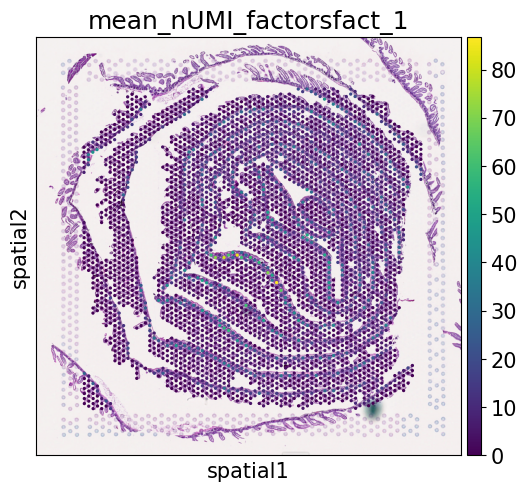

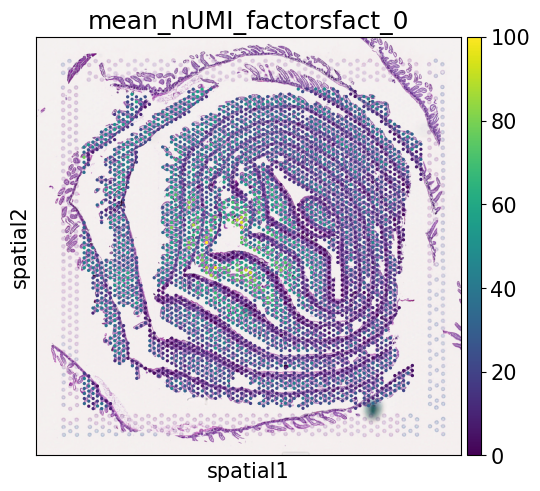

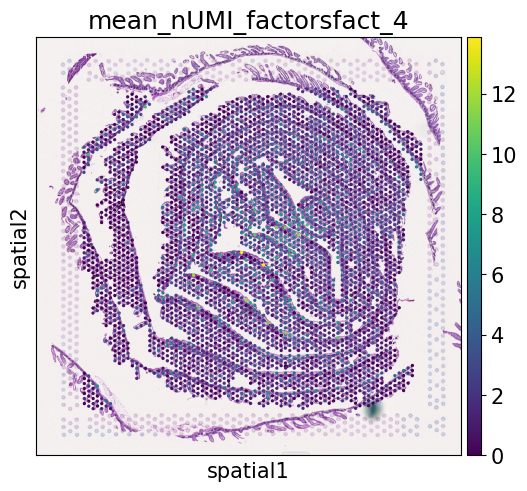

In [41]:
matplotlib.rcParams.update({'font.size': 15})

sq.pl.spatial_scatter(merge_dataset, color = "location")
sq.pl.spatial_scatter(merge_dataset, color = "mean_nUMI_factorsfact_3")
sq.pl.spatial_scatter(merge_dataset, color = "mean_nUMI_factorsfact_2")
sq.pl.spatial_scatter(merge_dataset, color = "mean_nUMI_factorsfact_1")
sq.pl.spatial_scatter(merge_dataset, color = "mean_nUMI_factorsfact_0")
sq.pl.spatial_scatter(merge_dataset, color = "mean_nUMI_factorsfact_4")